In [1]:
import numpy as np
import pandas as pd

filename = "zillow_properties_data.json"
zillow_df = pd.read_json(filename)
relevant_cols = ["zpid", "city", "state", "bedrooms", "bathrooms", "price", "yearBuilt", "zipcode", "streetAddress", "livingArea","homeType"]
zillow_df = zillow_df[relevant_cols]

# Step 1: Remove rows where 'price' is NaN, infinite, or 0
zillow_df_clean = zillow_df[~zillow_df['price'].isnull()]  # Remove rows where 'price' is NaN
zillow_df_clean = zillow_df_clean[np.isfinite(zillow_df_clean['price'])]  # Remove rows where 'price' is infinite
zillow_df_clean = zillow_df_clean[zillow_df_clean['price'] != 0]  # Remove rows where 'price' is 0

relevant_df = zillow_df_clean[['bedrooms', 'bathrooms', 'homeType']]

relevant_df = pd.get_dummies(relevant_df, columns=['homeType'], drop_first=True)

relevant_df = relevant_df.astype(float)

relevant_df_simpler = relevant_df[['bedrooms', 'bathrooms'] + [col for col in relevant_df.columns if col.startswith('homeType_')]]

X = relevant_df_simpler.values

X = np.hstack([np.ones((X.shape[0], 1)), X])


y = zillow_df_clean['price'].values


X_T_X = np.linalg.pinv(np.dot(X.T, X))  # Use pseudoinverse
X_T_y = np.dot(X.T, y)
beta_hat = np.dot(X_T_X, X_T_y)

print("Estimated coefficients (bedrooms, bathrooms, and homeType):", beta_hat)

print(relevant_df_simpler.columns)

Estimated coefficients (bedrooms, bathrooms, and homeType): [-298833.28902092   31639.40435042  217777.24016025  301666.79978194
   58796.11811311   40983.71097057  186489.78089239  136905.76106806]
Index(['bedrooms', 'bathrooms', 'homeType_CONDO', 'homeType_MANUFACTURED',
       'homeType_MULTI_FAMILY', 'homeType_SINGLE_FAMILY',
       'homeType_TOWNHOUSE'],
      dtype='object')


In [2]:
y_pred = np.dot(X, beta_hat)

residuals = y - y_pred

ss_total = np.sum((y - np.mean(y)) ** 2)  # Total sum of squares
ss_residual = np.sum(residuals ** 2)  # Residual sum of squares
r_squared = 1 - (ss_residual / ss_total)

mse = np.mean(residuals ** 2)

print(f"R-squared: {r_squared}")
print(f"Mean Squared Error (MSE): {mse}")


R-squared: 0.2661306905395351
Mean Squared Error (MSE): 157843269436.72226


In [3]:
# Filter out instances where actual prices (y) are zero to avoid division by zero
non_zero_indices = y != 0 

mape = np.mean(np.abs((y[non_zero_indices] - y_pred[non_zero_indices]) / y[non_zero_indices])) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")



Mean Absolute Percentage Error (MAPE): 78.39%


In [4]:
# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 397294.9401096398


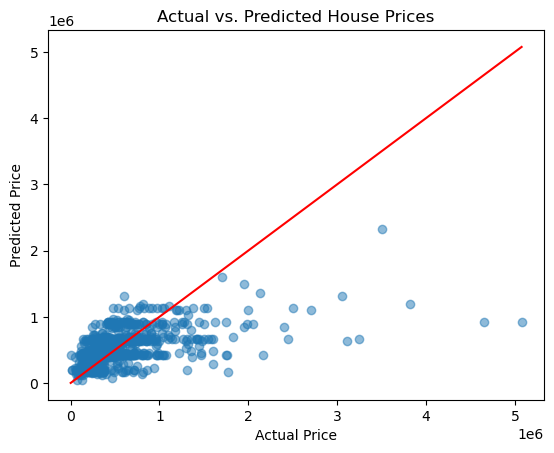

In [5]:
import matplotlib.pyplot as plt

plt.scatter(y, y_pred, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted House Prices")

plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red')

plt.show()


In [6]:
correlation_matrix = relevant_df_simpler.corr()
print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                        bedrooms  bathrooms  homeType_CONDO  \
bedrooms                1.000000   0.570523       -0.302702   
bathrooms               0.570523   1.000000       -0.102434   
homeType_CONDO         -0.302702  -0.102434        1.000000   
homeType_MANUFACTURED  -0.054787  -0.064587       -0.035644   
homeType_MULTI_FAMILY   0.181540   0.049271       -0.035644   
homeType_SINGLE_FAMILY  0.240050   0.065926       -0.616490   
homeType_TOWNHOUSE     -0.132360   0.018160       -0.057190   

                        homeType_MANUFACTURED  homeType_MULTI_FAMILY  \
bedrooms                            -0.054787               0.181540   
bathrooms                           -0.064587               0.049271   
homeType_CONDO                      -0.035644              -0.035644   
homeType_MANUFACTURED                1.000000              -0.019251   
homeType_MULTI_FAMILY               -0.019251               1.000000   
homeType_SINGLE_FAMILY              -0.3329

In [7]:
y_log = np.log(y)

# Re-run the regression with log-transformed prices
X_T_X_log = np.linalg.pinv(np.dot(X.T, X))  # Use pseudoinverse
X_T_y_log = np.dot(X.T, y_log)
beta_hat_log = np.dot(X_T_X_log, X_T_y_log)

print("Estimated coefficients (log-transformed price):", beta_hat_log)

# Predict prices (in log scale) and transform back to original scale by exponentiating
y_pred_log = np.exp(np.dot(X, beta_hat_log))

residuals_log = y - y_pred_log

# Calculate R-squared and MSE for the log-transformed model
ss_total_log = np.sum((y - np.mean(y)) ** 2)  # Total sum of squares
ss_residual_log = np.sum(residuals_log ** 2)  # Residual sum of squares
r_squared_log = 1 - (ss_residual_log / ss_total_log)
mse_log = np.mean(residuals_log ** 2)

# Print R-squared and MSE for the log-transformed model
print(f"R-squared (log-transformed price): {r_squared_log}")
print(f"Mean Squared Error (MSE, log-transformed price): {mse_log}")


Estimated coefficients (log-transformed price): [11.37352784  0.05507962  0.36119279  0.69119713  0.02571974  0.22974573
  0.48712982  0.41231279]
R-squared (log-transformed price): 0.15144607015085743
Mean Squared Error (MSE, log-transformed price): 182510053021.89066


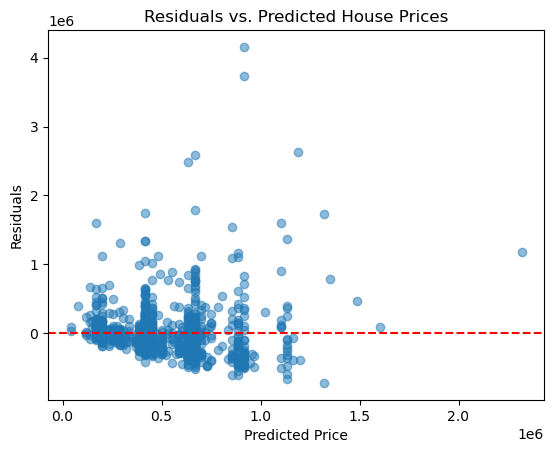

In [8]:
residuals = y - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted House Prices")
plt.show()


In [9]:
# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 397294.9401096398


In [10]:
# Sort the dataset by price to identify high-priced outliers
outliers = zillow_df_clean.sort_values(by='price', ascending=False).head(20)

# Print the top 20 most expensive houses
print(outliers[['bedrooms', 'bathrooms', 'price']])


     bedrooms  bathrooms    price
19          5        4.0  5073800
680         5        4.0  4650000
23          3        5.0  3820000
891         8       10.0  3500000
96          4        3.0  3250000
929         3        3.0  3115000
700         4        6.0  3050000
551         4        5.0  2699500
515         5        5.0  2502100
286         4        3.0  2450000
101         3        4.0  2400000
857         3        2.0  2160000
763         5        6.0  2133200
193         4        4.0  2057000
195         4        5.0  2000000
445         4        4.0  1988000
851         3        4.0  1950000
455         4        7.0  1950000
197         5        3.0  1822800
753         2        1.0  1768000


In [11]:
# Create categories for bedrooms and bathrooms
relevant_df['bedrooms_cat'] = pd.cut(relevant_df['bedrooms'], bins=[0, 2, 3, 4, 5, np.inf], labels=['0-2', '3', '4', '5', '6+'])
relevant_df['bathrooms_cat'] = pd.cut(relevant_df['bathrooms'], bins=[0, 1.5, 2.5, 3.5, np.inf], labels=['0-1.5', '2-2.5', '3-3.5', '4+'])

# Create dummy variables for bedrooms and bathrooms categories
relevant_df = pd.get_dummies(relevant_df, columns=['bedrooms_cat', 'bathrooms_cat'], drop_first=True)

relevant_df_simpler = relevant_df[['bedrooms_cat_3', 'bedrooms_cat_4', 'bedrooms_cat_5', 'bedrooms_cat_6+', 
                                   'bathrooms_cat_2-2.5', 'bathrooms_cat_3-3.5', 'bathrooms_cat_4+'] + 
                                   [col for col in relevant_df.columns if col.startswith('homeType_')]]

relevant_df_simpler = relevant_df_simpler.astype(float)
X = relevant_df_simpler.values

X = np.hstack([np.ones((X.shape[0], 1)), X])

X_T_X = np.linalg.pinv(np.dot(X.T, X))  # Use pseudoinverse
X_T_y = np.dot(X.T, y)
beta_hat = np.dot(X_T_X, X_T_y)

print("Estimated coefficients with categorized bedrooms and bathrooms:", beta_hat)


Estimated coefficients with categorized bedrooms and bathrooms: [ 98645.91415498  55410.08657723 103525.78373592 176458.35545095
 205718.13235475 101354.08584499 265620.84086018 662319.33040496
 264528.31171263  30003.23679914  18000.20281306 149570.20018753
 124271.69248309]


In [12]:
y_pred = np.dot(X, beta_hat)

residuals = y - y_pred

ss_total = np.sum((y - np.mean(y)) ** 2)  # Total sum of squares
ss_residual = np.sum(residuals ** 2)  # Residual sum of squares
r_squared = 1 - (ss_residual / ss_total)

mse = np.mean(residuals ** 2)

rmse = np.sqrt(mse)

# Print R-squared, MSE, and RMSE
print(f"R-squared: {r_squared}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


R-squared: 0.2350965712764045
Mean Squared Error (MSE): 164518200225.39777
Root Mean Squared Error (RMSE): 405608.43214287073


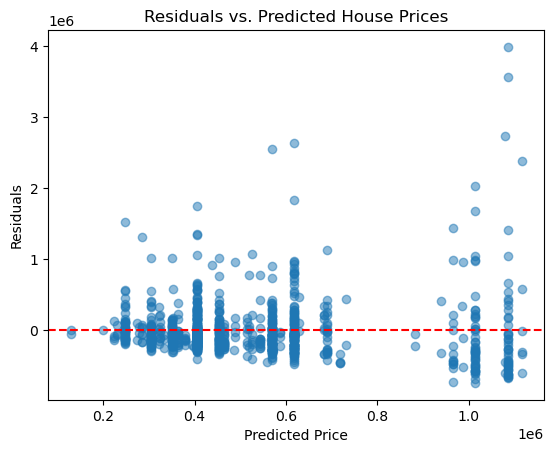

In [13]:
# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted House Prices")
plt.show()


In [14]:
# Apply log transformation to the price
y_log = np.log(y)

# Re-run the regression with log-transformed prices
X_T_X_log = np.linalg.pinv(np.dot(X.T, X))  # Use pseudoinverse
X_T_y_log = np.dot(X.T, y_log)
beta_hat_log = np.dot(X_T_X_log, X_T_y_log)

# Predict prices (in log scale) and transform back to original scale by exponentiating
y_pred_log = np.exp(np.dot(X, beta_hat_log))

residuals_log = y - y_pred_log

# Calculate R-squared and MSE for log-transformed model
ss_total_log = np.sum((y - np.mean(y)) ** 2)  # Total sum of squares
ss_residual_log = np.sum(residuals_log ** 2)  # Residual sum of squares
r_squared_log = 1 - (ss_residual_log / ss_total_log)
mse_log = np.mean(residuals_log ** 2)
rmse_log = np.sqrt(mse_log)

# Print R-squared and RMSE for log-transformed model
print(f"R-squared (log-transformed price): {r_squared_log}")
print(f"Root Mean Squared Error (RMSE, log-transformed price): {rmse_log}")


R-squared (log-transformed price): 0.19821127755653878
Root Mean Squared Error (RMSE, log-transformed price): 415272.9497709196


In [15]:
relevant_columns_correlation = ['bedrooms', 'bathrooms', 'livingArea']
# Drop rows where bedrooms, bathrooms, or livingArea have missing values
filtered_df_correlation = zillow_df[relevant_columns_correlation].dropna()

correlation_matrix = filtered_df_correlation.corr()

print("Correlation Matrix:")
print(correlation_matrix)

correlation_matrix = filtered_df_correlation[relevant_columns_correlation].corr()

print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
            bedrooms  bathrooms  livingArea
bedrooms    1.000000   0.570719    0.637058
bathrooms   0.570719   1.000000    0.771236
livingArea  0.637058   0.771236    1.000000
Correlation Matrix:
            bedrooms  bathrooms  livingArea
bedrooms    1.000000   0.570719    0.637058
bathrooms   0.570719   1.000000    0.771236
livingArea  0.637058   0.771236    1.000000


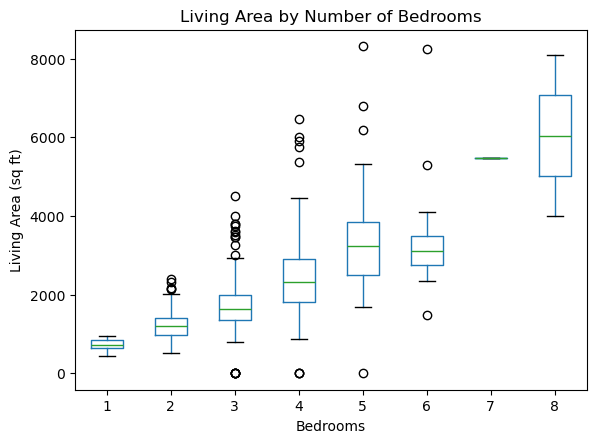

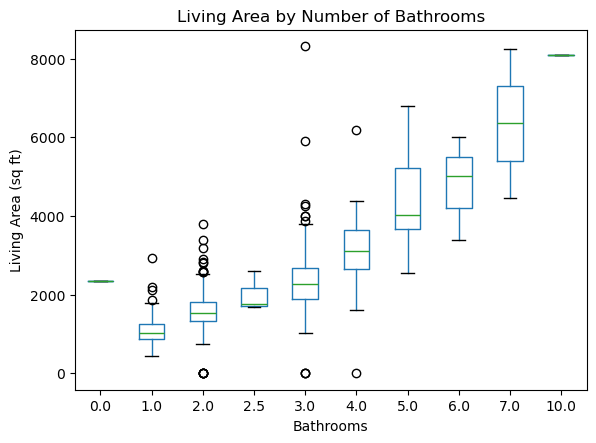

In [16]:
# Box plot: Living Area by Number of Bedrooms
filtered_df_correlation.boxplot(column='livingArea', by='bedrooms', grid=False)
plt.xlabel("Bedrooms")
plt.ylabel("Living Area (sq ft)")
plt.title("Living Area by Number of Bedrooms")
plt.suptitle("")  # Suppress the default title
plt.show()

# Box plot: Living Area by Number of Bathrooms
filtered_df_correlation.boxplot(column='livingArea', by='bathrooms', grid=False)
plt.xlabel("Bathrooms")
plt.ylabel("Living Area (sq ft)")
plt.title("Living Area by Number of Bathrooms")
plt.suptitle("")  # Suppress the default title
plt.show()

